In [26]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
yasserhessein_dataset_alzheimer_path = kagglehub.dataset_download('yasserhessein/dataset-alzheimer')

print('Data source import complete.')


Data source import complete.


In [ ]:
#!pip install tensorflow

In [28]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import warnings
from tensorflow.keras.optimizers import AdamW
warnings.filterwarnings('ignore')

dataset_path = "/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/train/"

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 50

In [31]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [32]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

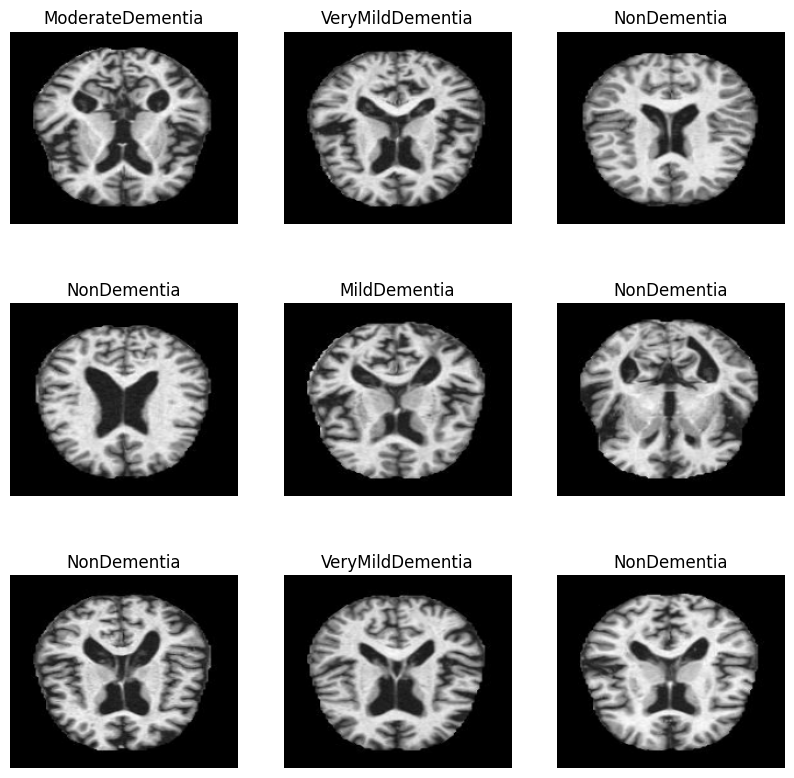

In [33]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [34]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [35]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
NUM_IMAGES = []

for label in class_names:
    dir_name = dataset_path + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [38]:
NUM_IMAGES

[717, 52, 2560, 1792]

In [39]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        #tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [40]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [41]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        #tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

In [43]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc')]

    optimizer = AdamW(learning_rate=1e-4)

    model.compile(
        optimizer=optimizer,
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [44]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [45]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.7513 - auc: 0.7321 - loss: 1.2991 - precision: 0.5076 - recall: 0.3048 - val_accuracy: 0.6858 - val_auc: 0.7423 - val_loss: 1.1608 - val_precision: 0.3651 - val_recall: 0.3477 - learning_rate: 0.0100
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.7733 - auc: 0.8006 - loss: 0.9994 - precision: 0.6002 - recall: 0.2834 - val_accuracy: 0.6743 - val_auc: 0.6912 - val_loss: 6.9600 - val_precision: 0.3486 - val_recall: 0.3486 - learning_rate: 0.0089
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.7779 - auc: 0.8027 - loss: 0.9888 - precision: 0.6329 - recall: 0.2641 - val_accuracy: 0.7600 - val_auc: 0.7633 - val_loss: 1.0592 - val_precision: 0.5494 - val_recall: 0.2227 - learning_rate: 0.0079
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.7886 - auc: 0.8236 - loss: 0.9401 - precision: 0.6767 - recall: 0.2954 - val_accuracy: 0.7969 - val_auc: 0.8336 - val_loss: 0.9427 -

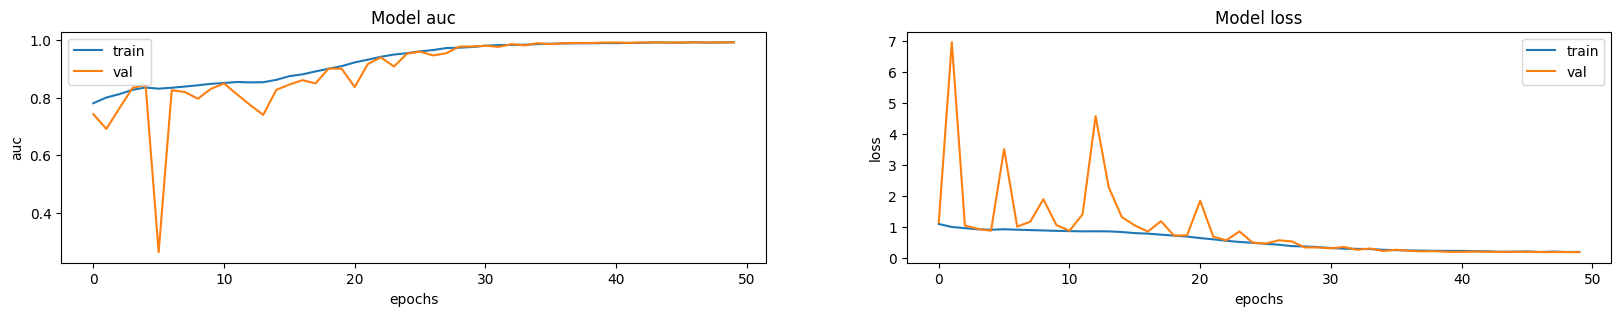

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [48]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [49]:
_ = model.evaluate(test_ds)

80/80 ━━━━━━━━━━━━━━━━━━━━ 28s 353ms/step - accuracy: 0.8444 - auc: 0.8756 - loss: 1.1518 - precision: 0.6912 - recall: 0.6827


In [50]:
model.save('saved_model.keras')

In [52]:
new_model = tf.keras.models.load_model('saved_model.keras')

# Show the model architecture
new_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 176, 208, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 176, 208, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 88, 104, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 44, 52, 32)     │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 22, 26, 64)     │         7,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 11, 13, 128)    │        27,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 11, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 5, 6, 256)      │       103,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 512)            │     3,934,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 128)            │        66,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,452,334 (47.50 MB)

 Trainable params: 4,149,988 (15.83 MB)

 Non-trainable params: 2,368 (9.25 KB)

 Optimizer params: 8,299,978 (31.66 MB)

In [53]:
if os.path.exists('saved_model.keras'):
    print("Model saved at:", os.path.abspath('saved_model.keras'))
else:
    print("Model not found in the current directory.")

Model saved at: /content/saved_model.keras


In [54]:
from google.colab import files
files.download('saved_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>